In [1]:
import torch

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import sklearn.metrics as measure
import numpy as np


classifiers = {

    "Neural Net": MLPClassifier(activation='relu', alpha=0.005, learning_rate='constant', hidden_layer_sizes = (128, 64, 32), solver = 'adam', random_state=10),
    
}



In [2]:
def align_video_audio_embeddings(filenames, vid):
    vid_embed_audio_order = []
    # for file in audio['filenames']:
    for file in filenames:
        postindex = file[0:4]
        file_mp4 = str(postindex) + ".mp4"
        vid_id = vid['filenames'].index(file_mp4)
        vid_embed = vid['embeddings'][vid_id]
        vid_embed_audio_order.append(vid_embed)

    return vid_embed_audio_order

In [25]:
# def get_stats(t):
#      print("(min, max): ({:.2f},{:.2f})".format(t.min(), t.max()))        
#      print("(avg, std): ({:.2f},{:.2f})".format(t.mean(), t.std()))

In [3]:
# #change key name in dictionary
# def change_key_name(dictionary, old_key, new_key):
#     dictionary[new_key] = dictionary.pop(old_key)
#     return dictionary

In [9]:
def concat_audio_video(audio_embed, video_embed):
    if audio_embed == 'pa': #Use pre-trained audio embeddings
        TRAIN_DATA_PATH_1 = "../../data/embeddings/wav2vec/pretrained_out/audio_trn_0-150_embeddings.pt"
        TRAIN_DATA_PATH_2 = "../../data/embeddings/wav2vec/pretrained_out/audio_trn_150-300_embeddings.pt"
        TRAIN_DATA_PATH_3 = "../../data/embeddings/wav2vec/pretrained_out/audio_trn_300-440_embeddings.pt"
        VAL_DATA_PATH = "../../data/embeddings/wav2vec/pretrained_out/audio_val_0-108_embeddings.pt"

    if audio_embed == 'fa':
        TRAIN_DATA_PATH_1 = "../../data/embeddings/wav2vec/finetuned_out/audio_trn_0-150_best_embeddings.pt"
        TRAIN_DATA_PATH_2 = "../../data/embeddings/wav2vec/finetuned_out/audio_trn_150-300_best_embeddings.pt"
        TRAIN_DATA_PATH_3 = "../../data/embeddings/wav2vec/finetuned_out/audio_trn_300-440_best_embeddings.pt"
        VAL_DATA_PATH = "../../data/embeddings/wav2vec/finetuned_out/audio_val_0-108_best_embeddings.pt"

    if video_embed == 'pv':
        vid_train_PATH = "../../data/embeddings/exp_00b_trn_embeddings.pt"
        vid_val_PATH = "../../data/embeddings/exp_00c_val_embeddings.pt"

    if video_embed == 'fv':
        vid_train_PATH = "../../data/embeddings/vid_trn_ftune.pt"
        vid_val_PATH = "../../data/embeddings/vid_val_ftune.pt"
        
    data_train_1 = torch.load(TRAIN_DATA_PATH_1)
    data_train_2 = torch.load(TRAIN_DATA_PATH_2)
    data_train_3 = torch.load(TRAIN_DATA_PATH_3)
    data_val = torch.load(VAL_DATA_PATH)


    vid_train = torch.load(vid_train_PATH)
    vid_val = torch.load(vid_val_PATH)

    x_trn_1, y_trn_1, filenames_1 = data_train_1["embeddings"].detach().numpy(), data_train_1["y"], data_train_1['filenames']
    x_trn_2, y_trn_2, filenames_2 = data_train_2["embeddings"].detach().numpy(), data_train_2["y"], data_train_2['filenames']
    x_trn_3, y_trn_3, filenames_3 = data_train_3["embeddings"].detach().numpy(), data_train_3["y"], data_train_3['filenames']

    filenames = filenames_1 + filenames_2 + filenames_3


    vid_train = torch.load(vid_train_PATH)
    print(vid_train.keys())
    # vid_train = change_key_name(vid_train, 'x_trn', 'embeddings')
    # vid_train = change_key_name(vid_train, 'y_trn', 'filenames')
    vid_val = torch.load(vid_val_PATH)
    # vid_val = change_key_name(vid_val, 'x_val', 'embeddings')
    # vid_val = change_key_name(vid_val, 'y_val', 'filenames')
    # x_trn_4, y_trn_4 = data_train_4["embeddings"].detach().numpy(), data_train_4["y"]

    x_audio_val, y_val = data_val["embeddings"].detach().numpy(), data_val["y"]

    x_audio_trn = np.vstack((x_trn_1, x_trn_2, x_trn_3))
    y_trn = np.hstack((y_trn_1, y_trn_2, y_trn_3))  

    vid_train_aligned = align_video_audio_embeddings(filenames, vid_train)
    vid_val_aligned = align_video_audio_embeddings(data_val['filenames'], vid_val)


    vid_train_embed = torch.stack(vid_train_aligned)
    vid_val_embed = torch.stack(vid_val_aligned)

    x_vid_trn = vid_train_embed.detach().numpy()
    x_vid_val = vid_val_embed.detach().numpy()

    # ss = StandardScaler()
    ss = MinMaxScaler()
    x_audio_trn_norm = ss.fit_transform(x_audio_trn)
    x_audio_val_norm = ss.transform(x_audio_val)

    # ss = StandardScaler()
    ss = MinMaxScaler()
    x_vid_trn_norm = ss.fit_transform(x_vid_trn)
    x_vid_val_norm = ss.transform(x_vid_val)

    # get_stats(x_audio_trn_norm)
    # get_stats(x_vid_trn_norm)


    #concaternate audio and video embeddings
    x_trn_norm = np.hstack((x_audio_trn_norm, x_vid_trn_norm))
    x_val_norm = np.hstack((x_audio_val_norm, x_vid_val_norm))

    mlp_gs = MLPClassifier(max_iter=1000, random_state=1)
    parameter_space = {
        'hidden_layer_sizes': [(10,30,10),(20,), (128, 64, 32, 16, 8)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.001, 0.01, 0.1, 0.0005, 0.005, .05, 0.5],
        'learning_rate': ['constant','adaptive'],
    }
    from sklearn.model_selection import GridSearchCV
    clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
    clf.fit(x_trn_norm, y_trn) # X is train samples and y is the corresponding labels

    print('Best parameters found:\n', clf.best_params_)

    pred_val = clf.predict(x_val_norm)
    accuracy = measure.accuracy_score(y_val, pred_val)
    print(f"{'NN'}: {accuracy:.3f}")

    disp = measure.ConfusionMatrixDisplay.from_predictions(
            y_val,
            pred_val,
            display_labels=["Dance (0.18)", "Couple Romance (0.32)",
                            "Heartbreak Romance (0.27)", "Memes (0.09)",
                            "Pranks (0.14)"],
            normalize="true",
            xticks_rotation=45
            )

    plt.savefig(audio_embed+'_'+video_embed+'_confusion_matrix.png')
    plt.show()





dict_keys(['embeddings', 'filenames'])


/home/shray/anaconda3/envs/mmaudio/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shray/anaconda3/envs/mmaudio/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shray/anaconda3/envs/mmaudio/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shray/anaconda3/envs/mmaudio/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.5, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'adam'}
NN: 0.537


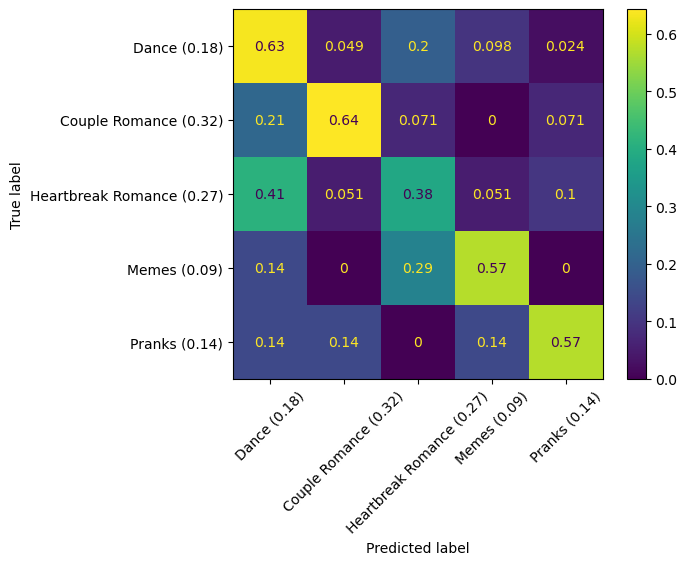

In [5]:
concat_audio_video('pa', 'pv')

dict_keys(['embeddings', 'filenames'])


/home/shray/anaconda3/envs/mmaudio/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shray/anaconda3/envs/mmaudio/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shray/anaconda3/envs/mmaudio/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shray/anaconda3/envs/mmaudio/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0005, 'hidden_layer_sizes': (128, 64, 32, 16, 8), 'learning_rate': 'constant', 'solver': 'adam'}
NN: 0.611


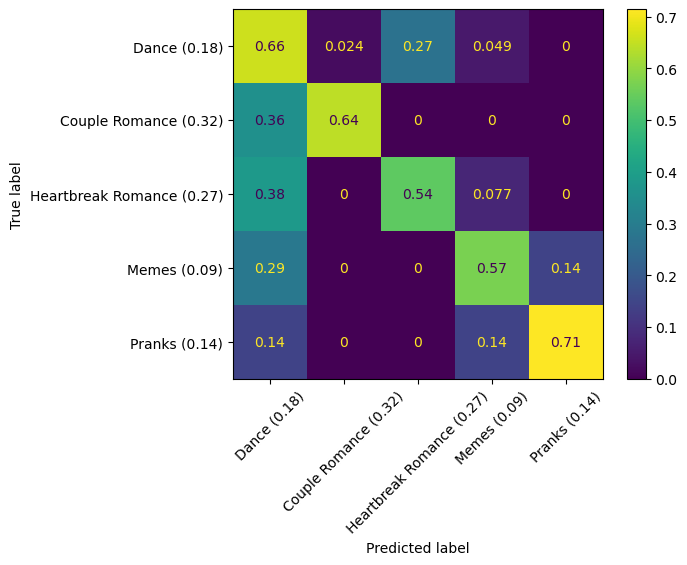

In [10]:
concat_audio_video('fa', 'pv')

dict_keys(['embeddings', 'filenames'])


/home/shray/anaconda3/envs/mmaudio/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shray/anaconda3/envs/mmaudio/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shray/anaconda3/envs/mmaudio/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shray/anaconda3/envs/mmaudio/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.5, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'adam'}
NN: 0.546


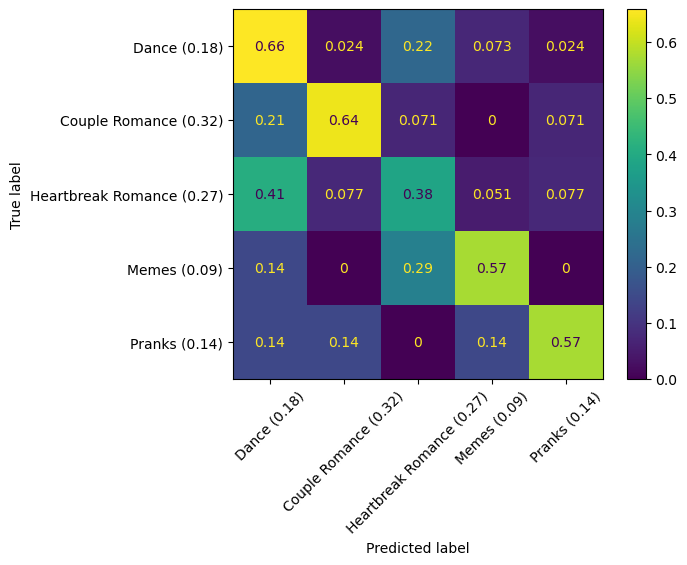

In [7]:
concat_audio_video('pa', 'fv')

dict_keys(['embeddings', 'filenames'])


/home/shray/anaconda3/envs/mmaudio/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shray/anaconda3/envs/mmaudio/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shray/anaconda3/envs/mmaudio/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shray/anaconda3/envs/mmaudio/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'constant', 'solver': 'sgd'}
NN: 0.593


/home/shray/anaconda3/envs/mmaudio/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


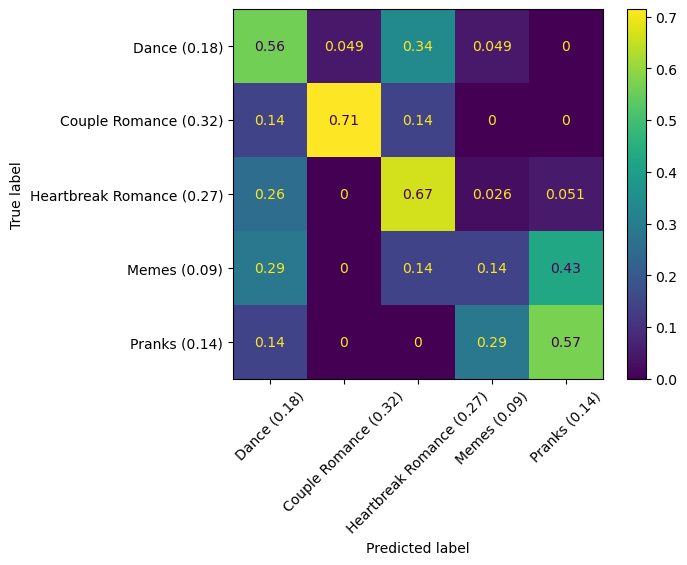

In [8]:
concat_audio_video('fa', 'fv')